<a href="https://colab.research.google.com/github/mira-create/un-report/blob/main/Data_Preprocessing_7_21_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
import scipy
from scipy import stats
from sklearn.preprocessing import PowerTransformer
import networkx as nx


#import virus data URL
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1GblpjwolJDNkmA6BPQis4HaInOO9EFgLYzNSlW-mTf4/edit#gid=0')
sheet = wb.sheet1
data = sheet.get_all_values()
df = pd.DataFrame(data)
df.columns = df.iloc[0]
experimental_data = df.iloc[1:]

#extract rows from datasets that have attached label values
data = experimental_data.loc[experimental_data['Data Extracted?']=='Y']


# Process Experimental Data

## Rename and select important columns

In [3]:
#extract rows from datasets that have attached label values
data = experimental_data.loc[experimental_data['Data Extracted?']=='Y']

#rename important columns to ease further processing
data = data.rename(columns={"Virus name and strain": "virus_name", "Strain details": "strain","Temperature (C)":'temp', "Paper ID":'paper_ID',"Virus purification type":'purification_level', "kobs with new code":'k_obs'});
data = data.rename(columns={"Buffer type": "buffer_type", "Chlorine Concentration" : "chlor_conc", "Sample ID" : "sample_ID","Year":"year", "Author_list_edit":"author_list"})
                            
#fill in incomplete values for strain and add a space
data['strain'] = data['strain'].fillna('').str.lower()
#make virus name lowercase
data['virus_name'] = data['virus_name'].str.lower()

#combine virus name and strain columns
data['virus_name_strain'] = data['virus_name'].str.replace("[ \t]+$",'', regex = True)+ ' ' + data['strain']

#extract only important columns
data = data.loc[:, ["virus_name","virus_name_strain","strain","temp", "pH", "paper_ID","kobs_mira","purification_level","buffer_type", "chlor_conc", "sample_ID", "average_kobs", "year", "author_list","buffer_type_9_23","corr_author","high_chloride"]] # Kaming: Added average_kobs here

In [4]:
data.columns

Index(['virus_name', 'virus_name_strain', 'strain', 'temp', 'pH', 'paper_ID',
       'kobs_mira', 'purification_level', 'buffer_type', 'chlor_conc',
       'sample_ID', 'average_kobs', 'year', 'author_list', 'buffer_type_9_23',
       'corr_author', 'high_chloride'],
      dtype='object', name=0)

## Temp and pH processing, full paper removal

In [5]:
#convert ID from string
data['paper_ID'] = data['paper_ID'].apply(pd.to_numeric)

#insert IDs of papers to remove
r = [4,24]
#remove 4 because no temp
#remove 24 because no pH
to_remove = pd.Series(r, copy=False)

data = data.loc[~data['paper_ID'].isin(to_remove)]

#replace temp with middle of temp range, and set room temp to 20 (68C)
data['temp'] = data['temp'].str.replace('20-25','22.5').str.replace('25-28','26.5').str.replace('25-26','25.5').str.replace('23-24','23.5').str.replace('1-5','3')
data['temp'] = data['temp'].str.replace('room temperature','20') 

#remova k values where we simply know that they are greater than a number to prevent outliers 
#since these valus are super large
data = data[~data['average_kobs'].str.contains(">")].reset_index(drop=True)
data = data[~data['average_kobs'].str.contains("<")].reset_index(drop=True)

#find null columns
#data[data['purification_level'].isnull()]

#convert numeric data to string
data['temp'] = data['temp'].apply(pd.to_numeric)
data['pH'] = data['pH'].apply(pd.to_numeric)
data['average_kobs'] = data['average_kobs'].apply(pd.to_numeric)

#find rate constant in terms of HOCl
pka = 7.53
data['alpha_0'] = 1/(1+ pow(10, -1* pka)/pow(10,-1*data['pH']) )
data['hocl_k_obs'] = data['average_kobs']/data['alpha_0']

#convert rate constant to all be at 20 C (room temp)
E_a = 54390 #J/mol, from Page 2009 for hadv 2
R = 8.314 #J/K*mol
T_2 = 20 + 273.15 #convert celcius to kelvin
data['hocl_20C_k_obs'] = data['hocl_k_obs']*np.exp(-E_a/R*(1/T_2-1/(data['temp']+273.15)))

## Author and buffer processing

In [6]:
#do this later
#data = data.replace(".*thurston-enriquez_j","thurston_j", regex = True) 
np.unique(data['corr_author'])
data['buffer'] = data['buffer_type_9_23']

#make all buffers synthetic buffer
data['buffer'] = data['buffer'].str.replace('phosphate saline','synthetic_buffer').str.replace('acetate','synthetic_buffer').str.replace('borate','synthetic_buffer').str.replace('phosphate carbonate','synthetic_buffer')
data['buffer'] = data['buffer'].str.replace('calcium','synthetic_buffer').str.replace('carbonate','synthetic_buffer').str.replace('magnesium','synthetic_buffer').str.replace('phthlate','synthetic_buffer')
data['buffer'] = data['buffer'].str.replace('phosphate','synthetic_buffer')

#make natural and treated waters category
data['buffer'] = data['buffer'].str.replace('treated surface water','natural_or_treated_water').str.replace('tap water','natural_or_treated_water').str.replace('treated groundwater','natural_or_treated_water').str.replace('surface water','natural_or_treated_water')
data['buffer'] = data['buffer'].str.replace('treated water','natural_or_treated_water')

#make high organics category
data['buffer'] = data['buffer'].str.replace('lettuce wash water','high_organics').str.replace("wastewater","high_organics")



In [7]:
#print(data.loc[[57]])
np.unique(data['buffer'])

#data.loc[data['buffer']=='synthetic_buffer ']


array(['high_organics', 'natural_or_treated_water', 'synthetic_buffer',
       'ultrapure'], dtype=object)

In [8]:
#data['hocl_k_obs']*np.exp(-E_a/R*(1/T_2-1/(data['temp']+273.15)))


## Abbreviations and virus name cleaning

In [9]:
import re
#data processing of experimental data

experiment = data

#replace virus full name with abbreviation in experiment dataset
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace('poliovirus','pv')
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace('coxsackievirus','cv')
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace('echovirus','echo')
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace('human adenovirus','hadv')
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace('adenovirus','hadv')
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace('pepper mild mottle virus','pmmov')
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace('enterovirus','entero')
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace('hepatitis','hep')
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace('phi6','phi 6')

#remova trailing space
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("[ \t]+$",'', regex = True)

#set all MS2 to be the same
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("ms2.*",'ms2', regex = True)

#set all cvb5 faulkner to be the same
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("faulkner.*",'faulkner', regex = True)

#remove final an identifyer
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace(" an mg845887",'').str.replace(" an mg845888",'').str.replace(" an mg845889",'')
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace(" mg845890",'').str.replace(" mg845891",'').str.replace(" mg845892",'')
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace(" mg845893",'').str.replace(" mg845894",'').str.replace(" mg845895",'')

#pr772 simplification
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("baa-769-b1",'')

#hadv 2 these terms are both descriptors of the same thing. assume all hadv2 is same
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("vr-846",'strain 6').str.replace("strain 6","")

#remove dashes
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("b5-",'b5 ').str.replace("b4-",'b4 ').str.replace("b1-",'b1 ')

#assumption: all cv b3 is cv b3 nancy
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("cv b3",'cv b3 nancy').str.replace("nancy nancy",'nancy')

#remove prd1 strain designation (only using one)
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("dsm 19107",'')

#assumption: all phi6 is the same
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("phi 6 atcc 21781-b1",'phi 6')

#remove fr strain designation, add bacteriophage to fr and ga
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("atcc 15767-b1",'bacteriophage')
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("ga(\W|$)",'ga bacteriophage', regex = True)

#replace h1n1 h1n1 strain a/pr/8/34 vr-1469 with simpler
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("h1n1 strain a/pr/8/34 vr-1469",'h1n1 a/pr/8/34', regex = True)

#assumption: replace 77-1 cv b4 with cvb4 jvb (since this is a lab strain)
experiment["virus_name_strain"] = np.where(experiment["sample_ID"]=="77-1",'cv b4 jvb', experiment["virus_name_strain"])

#assumption: pv2 P712 is vaccine strain
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("pv 2 p712",'pv 2 sabin', regex = True)

#assumption: all hadv 41 is hadv 41 tak
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("hadv 41.*",'hadv 41 tak', regex = True)

#assumption: reovirus 3 lang is actually reovirus 1 lang
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("reovirus 3 lang",'reovirus 1 lang', regex = True)


#remove trailing spaces
experiment['virus_name_strain'] = experiment['virus_name_strain'].str.replace("[ \t]+$",'', regex = True)

#(sorted(experiment.virus_name_strain.unique()))


## Removal of specific viruses

In [10]:
#insert names of viruses to remove because I dont have genetic, shape, or other information about thiem

#remove pmmov from 3 because people told me was not an infectivity assay
#remove radv from 19 because I cannot find this
#remove V1 from 57 because I cannot find this
r = [ 'recombinant hadv serotype 5','pmmov pepiwatehachiman1', 'v1']
to_remove = pd.Series(r, copy=False)

experiment = experiment.loc[~data['virus_name_strain'].isin(to_remove)]


# Process Virus Reference Data

In [11]:
#import virus data URL
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1LYBdd0lce1add1vZse4IAL8YLklACDqqoICyhPo7kVw/edit#gid=1062889010')
sheet = wb.worksheet('6-6 Virus Details Consolidated')
data = sheet.get_all_values()
df = pd.DataFrame(data)
df.columns = df.iloc[0]
virus_data = df.iloc[1:]

## Rename and select important columns


In [12]:
#rename important columns
virus_data = virus_data.rename(columns={"Virus Name": "virus_name", "Baltimore Class": "balt_class", "Genome shape":'shape', "Family":'family',"Genus":'genus', "Strain":'strain'})
virus_data = virus_data.rename(columns={"Structure":'structure',"Tail":'tail',"Isoelectric Point": 'iep', "Species":'species', "Symmetry":'symmetry', "Tail":'tail'})
virus_data['virus_name_strain'] = virus_data['virus_name'].str.replace("[ \t]+$",'', regex = True) + ' ' + virus_data['strain']
virus_data['min_diameter'] = pd.to_numeric(virus_data['min_diameter'])
virus_data['max_diameter']= pd.to_numeric(virus_data['max_diameter'])
virus_data['diameter'] = (virus_data['min_diameter'] + virus_data['max_diameter'])/2

#take the average of min and max diameter to get diameter

reference = virus_data.loc[:, ["virus_name_strain","balt_class","family","genus","species","shape","iep","structure","symmetry","tail","diameter","CG_content","genome_length","C_percentage", "G_percentage", "A_percentage", "T_percentage", "U_percentage", "T_is_0", "U_is_0"]]

#reference = virus_data.loc[:,"virus_name_strain","balt_class","family","genus","species","shape","iep","structure","symmetry","tail","diameter","CG_content","genome_length","C_percentage", "G_percentage", "A_percentage", "T_percentage", "U_percentage", "T_is_0", "U_is_0"]

#make colums lowercase 
reference['virus_name_strain'] = reference['virus_name_strain'].str.lower()
reference['structure'] = reference['structure'].str.lower()

#remove trailing space
reference['shape']  = reference['shape'].str.replace("[ \t]+$",'', regex = True)


#replace other virus characteristics
reference['balt_class'] = reference['balt_class'].str.replace('-senseRNA','-ssRNA')



In [13]:
(reference.head())

,virus_name_strain,balt_class,family,genus,species,shape,iep,structure,symmetry,tail,diameter,CG_content,genome_length,C_percentage,G_percentage,A_percentage,T_percentage,U_percentage,T_is_0,U_is_0
1,h1n1 a/pr/8/34,-ssRNA,Orthomyxoviridae,Alphainfluenzavirus,Alphainfluenzavirus influenzae,segmented,4.5,enveloped,helical,no,100.0,43.32,13585,19.072506,24.247332,33.043798,0,23.636364,1,0
2,h5n1 a/cambodia/408008/2005 clade 1,-ssRNA,Orthomyxoviridae,Alphainfluenzavirus,Alphainfluenzavirus influenzae,segmented,,enveloped,helical,no,100.0,43.32,13585,19.072506,24.247332,33.043798,0,23.636364,1,0
3,h5n1 a/chicken/hong kong/d-0947/2006,-ssRNA,Orthomyxoviridae,Alphainfluenzavirus,Alphainfluenzavirus influenzae,segmented,,enveloped,helical,no,100.0,43.32,13585,19.072506,24.247332,33.043798,0,23.636364,1,0
4,h5n1 a/whooperswan/mongolia/244/2005,-ssRNA,Orthomyxoviridae,Alphainfluenzavirus,Alphainfluenzavirus influenzae,segmented,,enveloped,helical,no,100.0,43.32,13585,19.072506,24.247332,33.043798,0,23.636364,1,0
5,infectious hematopoietic necrosis virus wenatc...,-ssRNA,Rhabdoviridae,Novirhabdovirus,Novirhabdovirus salmonid,linear,,enveloped,helical,no,120.0,51.415,11131,27.38298,24.03198,29.04501,0,19.54002,1,0


## KAMING Add GC content, genome size, and nucleotide percentagge

In [14]:
#Kaming to add

from urllib.request import urlopen
import pandas as pd

from urllib.request import urlopen
import pandas as pd

def CG_percentage(GI_number, is_RNA):
    
    API_key = "ddef75b69ab8cc94ef68df46011907864f08"
    
    path = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=nucleotide&id="+str(GI_number)+"&api_key="+API_key+"&rettype=fasta"
    sequence_info = str(urlopen(path).read())
    print(sequence_info) # Testing
    
    # Note: use efetch in Eutility to get virus info in NBCI, each document has a GI number
    #       use GI number to do web scrabing, can put in a list of GI numbers to get multiple sequences at a time
    #       db = database (Entrez Database: Nucleotide (= nuccore), id = GI number)
    #       API key generated in my NBCI account
    #       rettype = fasta (FASTA format is optimal for web scraping; other formats like GenBank is readable)
    #       Other NBCI API functions: esearch, esummary (everything found in efetch can be found using summary; not the other around)

    
    # Search for keywords: genome 
    # (might have more than one keywords; therefore output all the indices and choose the last one)
    start = 0
    start_list = []
    while True: 
        start = sequence_info.find("genome", start)
        if start == -1: 
            break
        start_list.append(start)
        start += len("genome")
        
    index_after_genome = start_list[-1] + len('genome')
    
    # Get the Sequence
    original_sequence = sequence_info[index_after_genome::]   # Testing
    sequence = sequence_info[index_after_genome::]
    sequence = sequence.replace("\\n", "") # remove "\\n" before "\n" because of the case \\n
    sequence = sequence.replace("\n", "")
    sequence = sequence.replace(" ", "")
    sequence = sequence.replace("'", "")
    for i in range(0,10): # Replace any number in teh sequence
        sequence = sequence.replace(str(i), "")
    
    if is_RNA == True:
        sequence = sequence.replace("T", "U")
    
    # Calculate percentage of each nucleotide
    total_length = len(sequence)
    C_count = sequence.count('C')
    G_count = sequence.count('G')
    A_count = sequence.count('A')
    T_count = sequence.count('T')
    U_count = sequence.count('U')
    
    # CG percentage
    C_G_count = C_count + G_count
    CG_percentage = (C_G_count/total_length)*100
    CG_percentage = round(CG_percentage, 3)
    
    # C, G, A, T, U percentage
    nucleotide_count_list = [C_count, G_count, A_count, T_count, U_count]
    nucleotide_percentage_list = []
    for nu in nucleotide_count_list:
        per = (nu/total_length)*100
        nucleotide_percentage_list.append(per)
    
    
    # Get the virus name
    virus_name_noise1 = sequence_info.split(',')[0]
    virus_name_noise2 = virus_name_noise1.split('/')[0]
    virus_name_noise3 = virus_name_noise2.split('>')[1]
    virus_name_noise4 = virus_name_noise3.split('.')[1]
    virus_name_clean = virus_name_noise4[2:]

    # Summary
    print(virus_name_clean)
    
    if is_RNA == True:
        print("* Converted DNA to RNA by replacing T with U *")
    else: 
        print("* DNA *")
    name_length = len(virus_name_clean)
    print("="*20)
    print(f"Genome length: {total_length}")
    print(f"CG content: {CG_percentage}")
    print()
    print(f"Nucleotide: {set(sequence)}")
    
    summary_dict = {"Nucleotide": ["C", "G", "A", "T", "U"],
                    "Count" : [C_count, G_count, A_count, T_count, U_count],
                    "Percentage": nucleotide_percentage_list}
    summary_df = pd.DataFrame(summary_dict)
    display(summary_df)
    
    return virus_name_clean, CG_percentage, sequence, index_after_genome, total_length, sequence_info, original_sequence 


In [15]:
#virus_name, percentage, sequence, index_after_genome, total_length, sequence_info, original_sequence = CG_percentage(9630643, is_RNA = True)

## Combine Segment Genomes

In [16]:
def CG_percentage_special(GI_number, key_word, is_RNA):
    
    API_key = "ddef75b69ab8cc94ef68df46011907864f08"
    
    path = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=nucleotide&id="+str(GI_number)+"&api_key="+API_key+"&rettype=fasta"
    sequence_info = str(urlopen(path).read())
    
#     print(sequence_info) # Testing
    
    # Note: use efetch in Eutility to get virus info in NBCI, each document has a GI number
    #       use GI number to do web scrabing, can put in a list of GI numbers to get multiple sequences at a time
    #       db = database (Entrez Database: Nucleotide (= nuccore), id = GI number)
    #       API key generated in my NBCI account
    #       rettype = fasta (FASTA format is optimal for web scraping; other formats like GenBank is readable)
    #       Other NBCI API functions: esearch, esummary (everything found in efetch can be found using summary; not the other around)

    
    # Search for keywords: genome/ cds/ sequence
    # (might have more than one keywords; therefore output all the indices and choose the last one)
    
#     keyword_list = key_word.split("|")
#     keyword_ind_list = []
#     for k in keyword_list:
#         ind = sequence_info.find(k)
#         if ind != -1:
#             keyword_ind_list.append(ind)
    
        
    
    start = 0
    start_list = []
    while True: 
        start = sequence_info.find(key_word, start)
        if start == -1: 
            break
        start_list.append(start)
        start += len(key_word)
        
    index_after_genome = start_list[-1] + len(key_word)
    
    # Get the Sequence
    original_sequence = sequence_info[index_after_genome::]   # Testing
    sequence = sequence_info[index_after_genome::]
    sequence = sequence.replace("\\n", "") # remove "\\n" before "\n" because of the case \\n
    sequence = sequence.replace("\n", "")
    sequence = sequence.replace(" ", "")
    sequence = sequence.replace("'", "")
    for i in range(0,10): # Replace any number in teh sequence
        sequence = sequence.replace(str(i), "")
    
    if is_RNA == True:
        sequence = sequence.replace("T", "U")
    
    # Get the virus name
    virus_name_noise1 = sequence_info.split(',')[0]
    virus_name_noise2 = virus_name_noise1.split('/')[0]
    virus_name_noise3 = virus_name_noise2.split('>')[1]
    virus_name_noise4 = virus_name_noise3.split('.')[1]
    virus_name_clean = virus_name_noise4[2:]

    return virus_name_clean, sequence, index_after_genome, sequence_info, original_sequence 


In [17]:
def get_segment_percentage(virus_name_clean, sequence, is_RNA):
    # Calculate percentage of each nucleotide
    total_length = len(sequence)
    C_count = sequence.count('C')
    G_count = sequence.count('G')
    A_count = sequence.count('A')
    T_count = sequence.count('T')
    U_count = sequence.count('U')
    
    # CG percentage
    C_G_count = C_count + G_count
    CG_percentage = (C_G_count/total_length)*100
    CG_percentage = round(CG_percentage, 3)
    
    # C, G, A, T, U percentage
    nucleotide_count_list = [C_count, G_count, A_count, T_count, U_count]
    nucleotide_percentage_list = []
    for nu in nucleotide_count_list:
        per = (nu/total_length)*100
        nucleotide_percentage_list.append(per)
    
    # Summary
    print(virus_name_clean)
    if is_RNA == True:
        print("* Converted DNA to RNA by replacing T with U *")
    else: 
        print("* DNA *")
    name_length = len(virus_name_clean)
    print("="*name_length)
    print(f"Genome length: {total_length}")
    print(f"CG content: {CG_percentage}")
    print()
    print(f"Nucleotide: {set(sequence)}")
    
    summary_dict = {"Nucleotide": ["C", "G", "A", "T", "U"],
                    "Count" : [C_count, G_count, A_count, T_count, U_count],
                    "Percentage": nucleotide_percentage_list}
    summary_df = pd.DataFrame(summary_dict)
    display(summary_df)
    

## Abbreviations and virus name cleaning

In [18]:
#data processing of reference data

#replace virus full name with abbreviation in experiment dataset
reference['virus_name_strain'] = reference['virus_name_strain'].str.replace('poliovirus','pv')
reference['virus_name_strain'] = reference['virus_name_strain'].str.replace('coxsackievirus','cv')
reference['virus_name_strain'] = reference['virus_name_strain'].str.replace('echovirus','echo')
reference['virus_name_strain'] = reference['virus_name_strain'].str.replace('human adenovirus','hadv')
reference['virus_name_strain'] = reference['virus_name_strain'].str.replace('adenovirus','hadv')
reference['virus_name_strain'] = reference['virus_name_strain'].str.replace('pepper mild mottle virus','pmmov')
reference['virus_name_strain'] = reference['virus_name_strain'].str.replace('enterovirus','entero')
reference['virus_name_strain'] = reference['virus_name_strain'].str.replace('hepatitis','hep')
reference['virus_name_strain'] = reference['virus_name_strain'].str.replace('phi6','phi 6')
reference['virus_name_strain'] = reference['virus_name_strain'].str.replace('none','')

#decided to use only one ms2, so i will remove identifyer
reference['virus_name_strain'] = reference['virus_name_strain'].str.replace("atcc 15597-b1",'')

#general mods
reference['virus_name_strain'] = reference['virus_name_strain'].str.replace("phi 6 phage",'phi 6')

reference['virus_name_strain'] = reference['virus_name_strain'].str.replace("2-85",'')

reference['virus_name_strain'] = reference['virus_name_strain'].str.replace("hep e virus",'hep e').str.replace("hep a virus",'hep a').str.replace("sar 55",'sar55')

reference['virus_name_strain'] = reference['virus_name_strain'].str.replace(" 7a,",'')

#assume all hadv2 is same
reference['virus_name_strain'] = reference['virus_name_strain'].str.replace("hadv 2 strain 6",'hadv 2')

#remove trailing space
reference['virus_name_strain'] = reference['virus_name_strain'].str.replace("[ \t]+$",'', regex = True)


# Merge Datasets

In [19]:
#merge dataset, using experimental data as key
merged_dataset = pd.merge(experiment, reference, how = 'left',  left_on='virus_name_strain', right_on='virus_name_strain')

#check merged dataset for missing values
merged_dataset[merged_dataset['buffer_type'].isnull()]
#len(merged_dataset[merged_dataset['balt_class'].isna()])

#merged_dataset['buffer_type'].value_counts()

#merged_dataset.isnull().sum()
merged_dataset = merged_dataset.drop(columns=['virus_name', 'strain'])

In [ ]:
(merged_dataset.groupby('family').agg('count'))

,virus_name_strain,temp,pH,paper_ID,kobs_mira,purification_level,buffer_type,chlor_conc,sample_ID,average_kobs,...,diameter,CG_content,genome_length,C_percentage,G_percentage,A_percentage,T_percentage,U_percentage,T_is_0,U_is_0
family,,,,,,,,,,,,,,,,,,,,,
Adenoviridae,63,63,63,63,63,63,63,63,63,63,...,63,63,63,63,63,63,63,63,63,63
Birnaviridae,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
Caliciviridae,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
Cystoviridae,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
Demerecviridae,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
Fiersviridae,72,72,72,72,72,72,72,72,72,72,...,72,72,72,72,72,72,72,72,72,72
Hepeviridae,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
Microviridae,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
Orthomyxoviridae,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5


In [ ]:
type(merged_dataset.author_list)


pandas.core.series.Series

# Exploratory Plots Kaming

Pearson Correlation

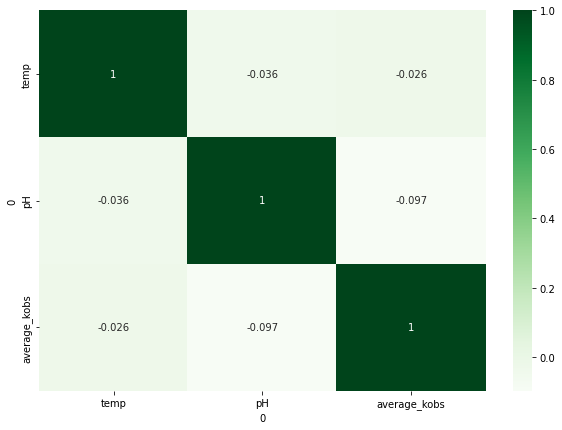

In [ ]:
plt.figure(figsize = (10,7))
sns.heatmap(merged_dataset[['temp', 'pH', 'average_kobs', 'purification_level', 'genome_length']].corr(), annot = True, cmap = "Greens")

Power Transformation: Yeo-johnson Transformation


In [ ]:
def plot_distribution(inp, bin_num):
    plt.figure(figsize = (15,5))
    ax = sns.distplot(inp, bins = bin_num, hist = True, hist_kws = {"alpha": 0.5})
    plt.axvline(np.mean(inp), color="k", linestyle="dashed", linewidth=2)
    _, max_ = plt.ylim()
    plt.text(
        inp.mean() + inp.mean() / 10,
        max_ - max_ / 10,
        "Mean: {:.2f}".format(inp.mean()),
    )
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


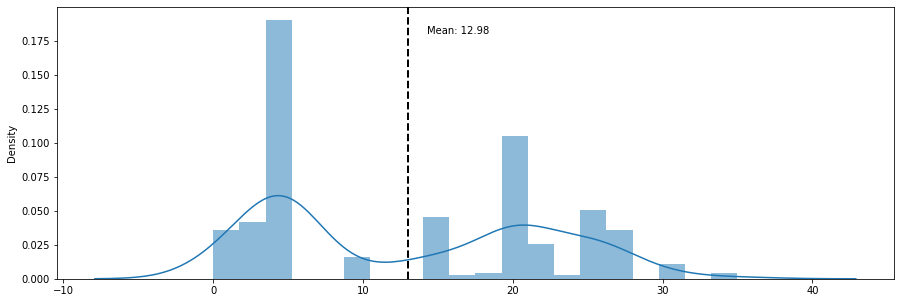

In [ ]:
# The distribution of temp

merged_dataset['temp'] = merged_dataset['temp'].astype(float)
temp_array = np.array(merged_dataset['temp'])
plot_distribution(temp_array, 20)

In [ ]:
len(merged_dataset)

562

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


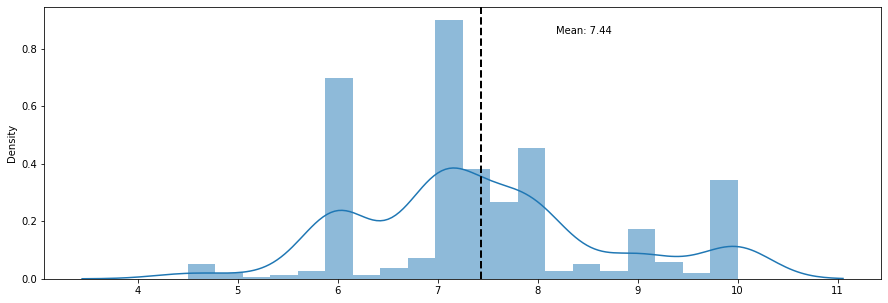

In [ ]:
# The distribution of pH

merged_dataset['pH'] = merged_dataset['pH'].astype(float)
pH_array = np.array(merged_dataset['pH'])
plot_distribution(pH_array, 20)

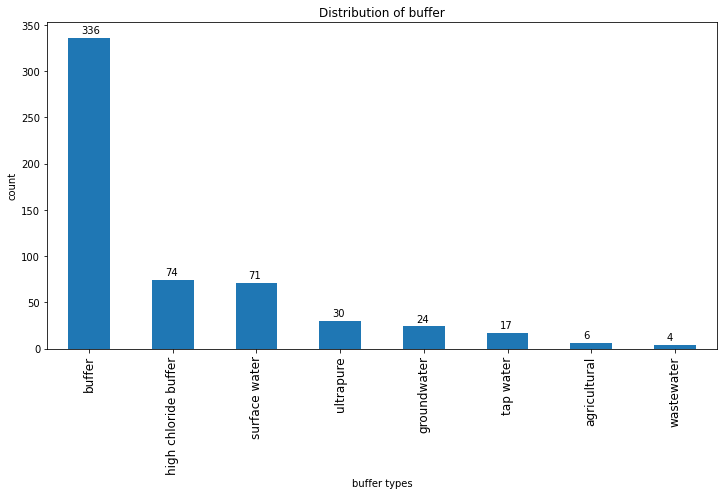

In [ ]:
# The distribution of buffer

fig, ax = plt.subplots(figsize = (12,6))
ax = merged_dataset['buffer_type'].value_counts().plot.bar()
ax.set_ylabel("count"); ax.set_xlabel('buffer types')
for i in ax.patches:
    ax.text(x = i.get_x()+0.155, y = i.get_height()+5, s = i.get_height())
ax.tick_params(axis = 'x', labelsize = 12)
ax.set_title("Distribution of buffer")
plt.show()

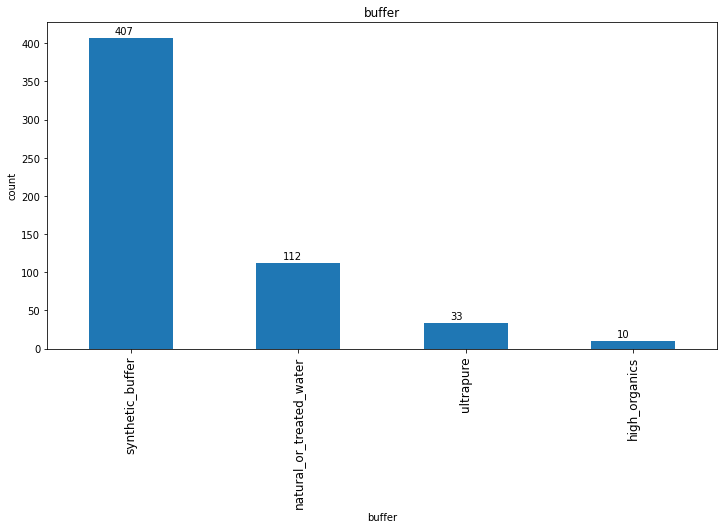

In [ ]:
# The distribution of buffer

fig, ax = plt.subplots(figsize = (12,6))
ax = merged_dataset['buffer'].value_counts().plot.bar()
ax.set_ylabel("count"); ax.set_xlabel('buffer')
for i in ax.patches:
    ax.text(x = i.get_x()+0.155, y = i.get_height()+5, s = i.get_height())
ax.tick_params(axis = 'x', labelsize = 12)
ax.set_title("buffer")
plt.show()

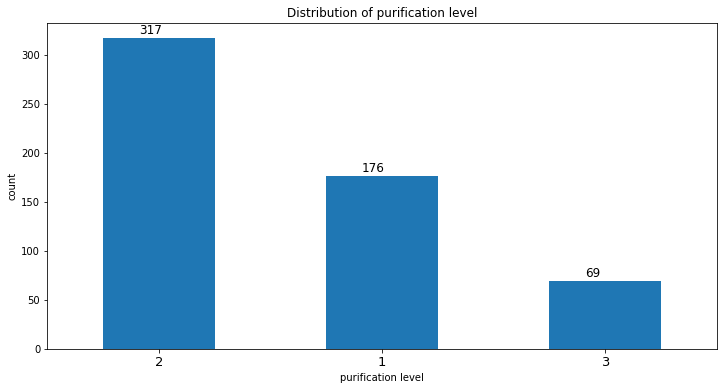

In [ ]:
# The distribution of purification level
fig, ax = plt.subplots(figsize = (12,6))
ax = merged_dataset['purification_level'].value_counts().plot.bar()
ax.set_ylabel("count"); ax.set_xlabel('purification level')
for i in ax.patches:
    ax.text(x = i.get_x()+0.16, y = i.get_height()+5, s = i.get_height(), fontsize = 12)
ax.tick_params(axis = 'x', labelsize = 13, rotation = 0)
ax.set_title("Distribution of purification level")

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


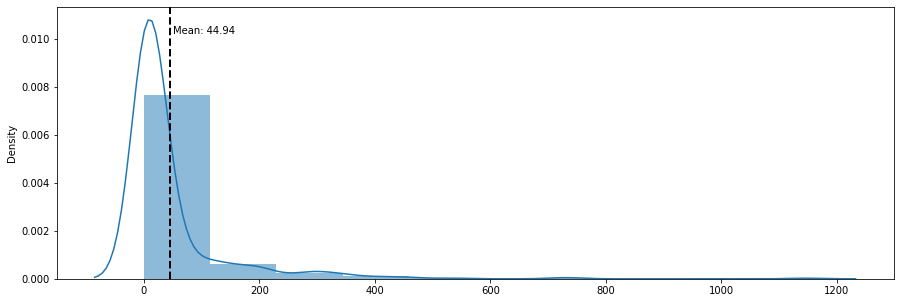

In [ ]:
# The distribution of k values

merged_dataset['average_kobs'] = merged_dataset['average_kobs'].astype(float)
k_array = np.array(merged_dataset['average_kobs'])
plot_distribution(k_array, 10)

In [ ]:
def ttest_Gaussian(arr):
    stat, p = scipy.stats.normaltest(arr)
    print(f"Statistic = {stat}, p-value = {p}")
    
    alpha = 0.05
    # H0: Is a Gaussian Distribution
    
    if p > alpha:
        print("Data looks Gaussian (Fail to reject H0)")
    else:
        print("Data doesn't look Gaussian (Reject H0)")

In [ ]:
def skew_kurt_before(df, var):
    print("Skewness (before): :", scipy.stats.skew(np.array(df[var]), axis = 0))
    print("Kurtosis (before): :", scipy.stats.kurtosis(np.array(df[var])))
    print()

def skew_kurt_after(df, ft_algo):
    print("Skewness (after) :", scipy.stats.skew(ft_algo, axis = 0))
    print("Kurtosis (after): :", scipy.stats.kurtosis(ft_algo))
    print()
    

In [ ]:
def power_transformation(df, var, algo):
    plt.figure(figsize = (13, 6))
    plt.subplot(121)
    sns.distplot(df[var])
    plt.title(f"Before Power Transformation: {var}")
    
    skew_kurt_before(df, var)
    
    plt.subplot(122)
    ft_algo = algo.fit_transform(df[[var]]).flatten()
    sns.distplot(ft_algo)
    plt.title(f"After Power Transformation: {var}")
    
    skew_kurt_after(df, ft_algo)
    ttest_Gaussian(ft_algo)
    

In [ ]:
def log_transformation(df, var):
    plt.figure(figsize = (13, 6))
    plt.subplot(121)
    sns.distplot(df[var])
    plt.title(f"Before Log Transformation: {var}")
    
    skew_kurt_before(df, var)
    
    plt.subplot(122)
    var_log = np.log(df[var])
    sns.distplot(var_log)
    plt.title(f"After Log Transformation: {var}")
    
    skew_kurt_after(df, var_log)
    ttest_Gaussian(var_log)   
    

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness (before): : 0.24514856182522554
Kurtosis (before): : -1.4216503889852685

Skewness (after) : -0.1454097992912574
Kurtosis (after): : -1.3598001837702494

Statistic = 2749.5929680852587, p-value = 0.0
Data doesn't look Gaussian (Reject H0)


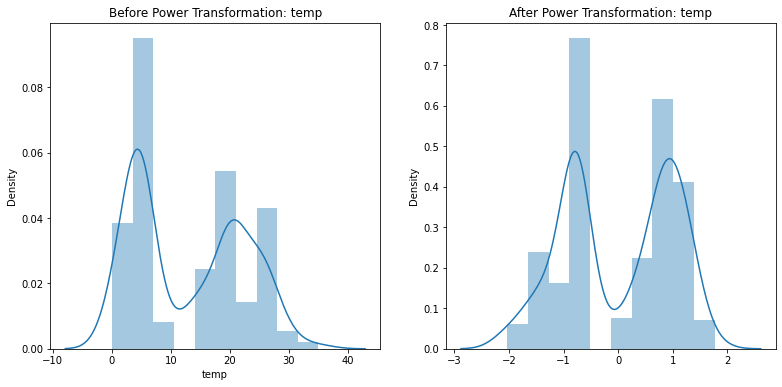

In [ ]:
# Transform temp 
power_transformation(merged_dataset, "temp", PowerTransformer(method = 'yeo-johnson'))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness (before): : 0.4230916733043862
Kurtosis (before): : -0.12866400446300696

Skewness (after) : -2.0184067646326853e-06
Kurtosis (after): : 0.0048570411278126

Statistic = 0.030294747177929553, p-value = 0.9849667708182764
Data looks Gaussian (Fail to reject H0)


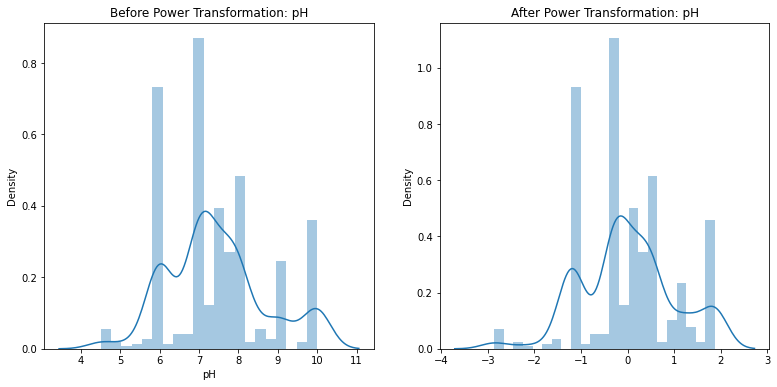

In [ ]:
# Transform pH

power_transformation(merged_dataset, "pH", PowerTransformer(method = 'yeo-johnson'))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness (before): : 4.847855404618245
Kurtosis (before): : 34.5053811911201

Skewness (after) : 0.0678932683211922
Kurtosis (after): : -0.710029452523051

Statistic = 29.325398713441192, p-value = 4.2861817181927903e-07
Data doesn't look Gaussian (Reject H0)


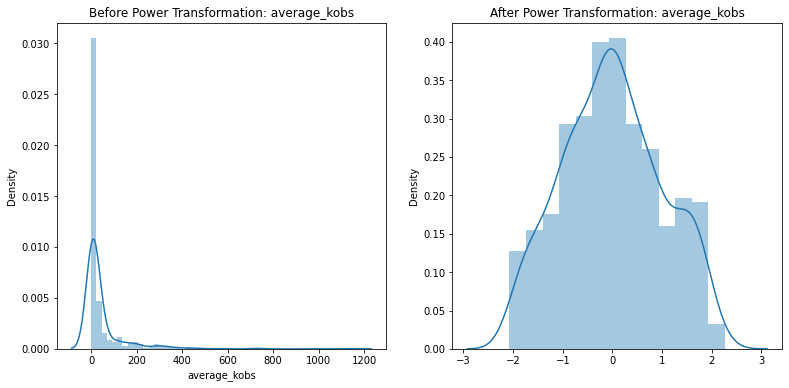

In [ ]:
# Transform k_obs

power_transformation(merged_dataset, "average_kobs", PowerTransformer(method = 'yeo-johnson'))

In [ ]:
# Use the Strage Rule to determine the numbers of bins

bin_num = 1

# Strip Plots

## Strip Plot

In [ ]:
(len(merged_dataset.family.unique()))

len(merged_dataset)

merged_dataset.groupby('virus_name_strain').agg('count').sort_values(by='temp')


,temp,pH,paper_ID,kobs_mira,purification_level,buffer_type,chlor_conc,sample_ID,average_kobs,year,...,diameter,CG_content,genome_length,C_percentage,G_percentage,A_percentage,T_percentage,U_percentage,T_is_0,U_is_0
virus_name_strain,,,,,,,,,,,,,,,,,,,,,
cv b5 l060815,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
fr bacteriophage,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
hadv 12 huie,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
entero 70 ahc(j670/71),1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
echo 9 vispo,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
echo 1 farouk,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27
cv b5 faulkner,35,35,35,35,35,35,35,35,35,35,...,35,35,35,35,35,35,35,35,35,35
hadv 2,46,46,46,46,46,46,46,46,46,46,...,46,46,46,46,46,46,46,46,46,46


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

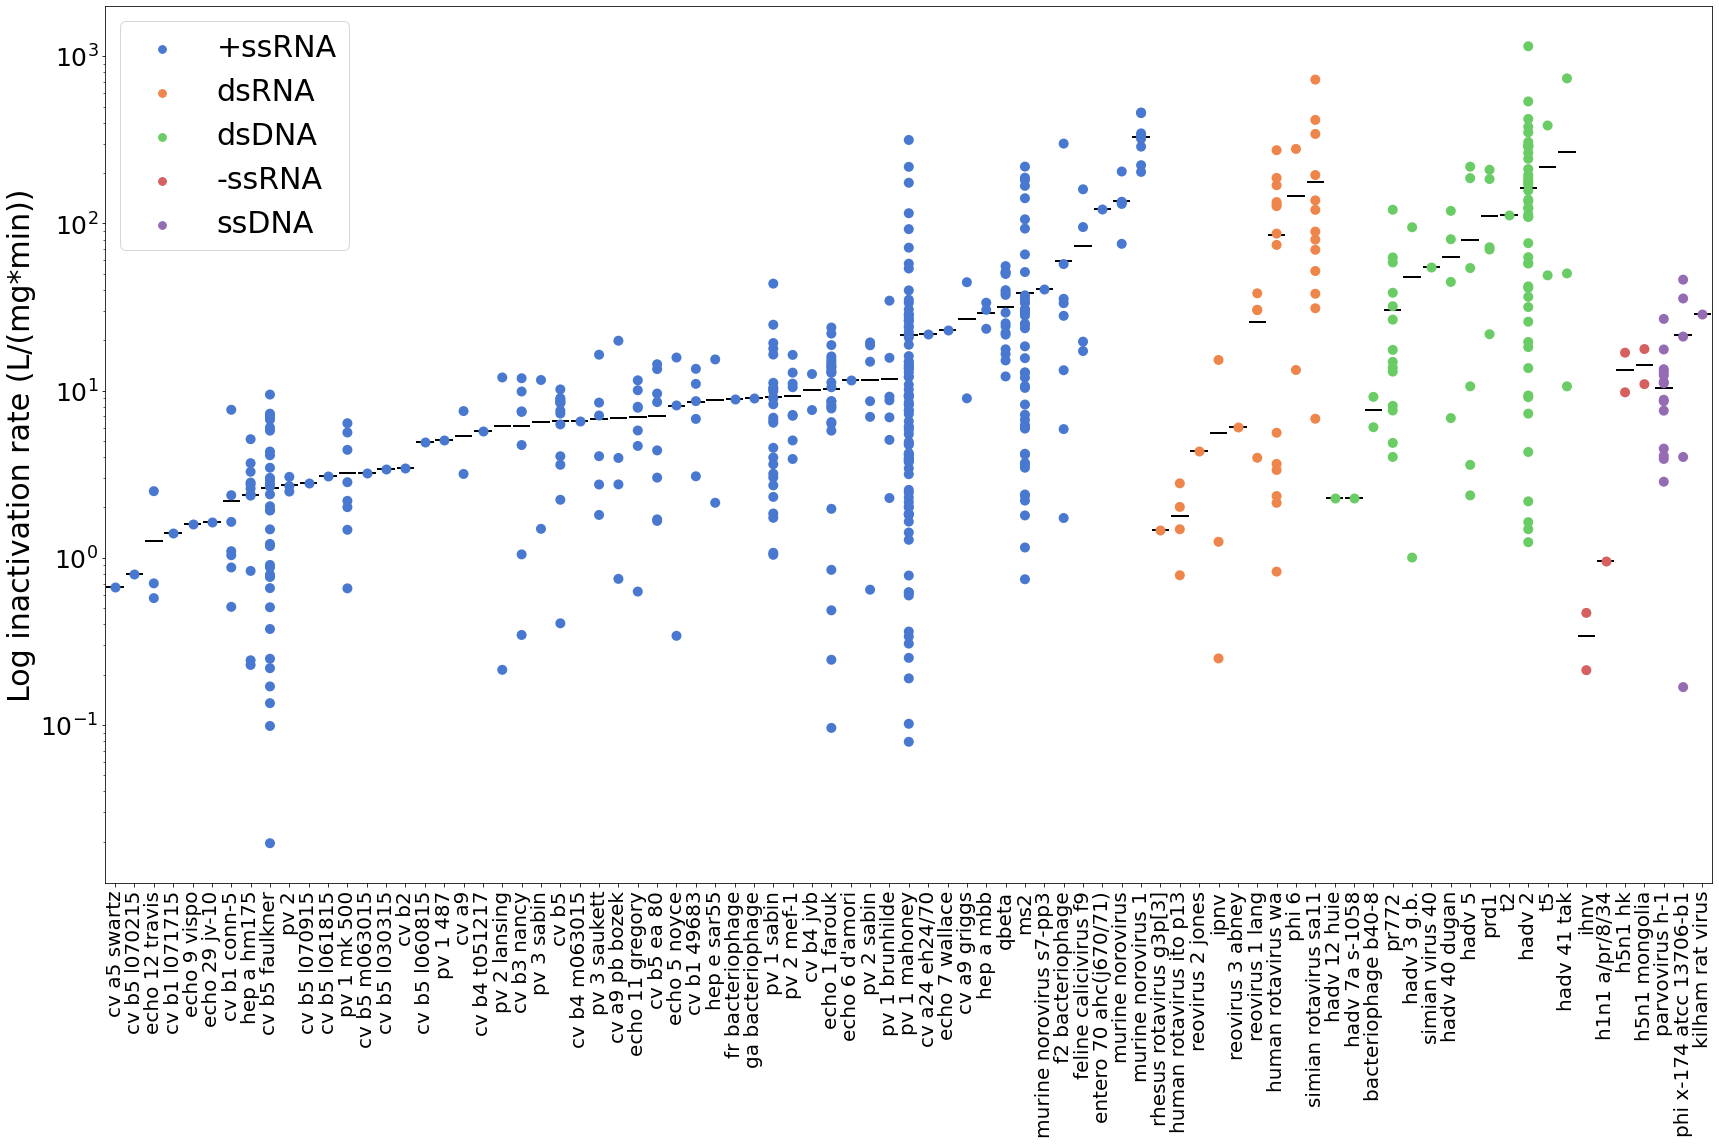

In [20]:
from google.colab import files

merged_dataset_strip = merged_dataset
k_to_use = "average_kobs"


#make names shorter
merged_dataset_strip['virus_name_strain'] = merged_dataset_strip['virus_name_strain'].str.replace('infectious pancreatic necrosis virus powder mill strain','ipnv')
merged_dataset_strip['virus_name_strain'] = merged_dataset_strip['virus_name_strain'].str.replace('infectious hematopoietic necrosis virus wenatchee river strain','ihnv')
merged_dataset_strip['virus_name_strain'] = merged_dataset_strip['virus_name_strain'].str.replace('h5n1 a/chicken/hong kong/d-0947/2006','h5n1 hk')
merged_dataset_strip['virus_name_strain'] = merged_dataset_strip['virus_name_strain'].str.replace('h5n1 a/whooperswan/mongolia/244/2005','h5n1 mongolia')


#from matplotlib import gridspec

#divide virus by genome type
plus_ssRNA_viruses = merged_dataset_strip.loc[merged_dataset_strip['balt_class']=='+ssRNA']
plus_ssRNA_ordered_mean = plus_ssRNA_viruses.groupby('virus_name_strain').agg(np.mean)[k_to_use].sort_values(ascending = True)
order1 = plus_ssRNA_ordered_mean.index.tolist()


dsRNA_viruses = merged_dataset_strip.loc[merged_dataset_strip['balt_class']=='dsRNA']
dsRNA_ordered_mean = dsRNA_viruses.groupby('virus_name_strain').agg(np.mean)[k_to_use].sort_values(ascending = True)
order2 = dsRNA_ordered_mean.index.tolist()


dsDNA_viruses = merged_dataset_strip.loc[merged_dataset_strip['balt_class']=='dsDNA']
dsDNA_ordered_mean = dsDNA_viruses.groupby('virus_name_strain').agg(np.mean)[k_to_use].sort_values(ascending = True)
order3 = dsDNA_ordered_mean.index.tolist()

neg_ssRNA_viruses = merged_dataset_strip.loc[merged_dataset_strip['balt_class']=='-ssRNA']
neg_ssRNA_viruses_ordered_mean = neg_ssRNA_viruses.groupby('virus_name_strain').agg(np.mean)[k_to_use].sort_values(ascending = True)
order4 = neg_ssRNA_viruses_ordered_mean.index.tolist()

neg_ssRNA_viruses = merged_dataset_strip.loc[merged_dataset_strip['balt_class']=='ssDNA']
neg_ssRNA_viruses_ordered_mean = neg_ssRNA_viruses.groupby('virus_name_strain').agg(np.mean)[k_to_use].sort_values(ascending = True)
order5 = neg_ssRNA_viruses_ordered_mean.index.tolist()


order = order1 + order2 + order3 + order4 + order5

#make  stripplot
f, ax = plt.subplots( figsize=(24, 16))
ax.set_yscale("log")
sns.stripplot(s = 10, data = merged_dataset_strip, x = "virus_name_strain", y = k_to_use, order = order, jitter = False, palette="muted", hue = 'balt_class')

sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            order=order,
            x="virus_name_strain",
            y=k_to_use,
            data=merged_dataset_strip,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=ax)

#labels and legends
ylabel ="Log inactivation rate (L/(mg*min))"
plt.xticks(rotation=90, size = 20)
plt.yticks(size = 25)
ax.set_ylabel(ylabel, fontsize=30)
ax.legend( prop={'size': 30})
ax.set(xlabel=None)
#plt.title('Summary of Virus Inactivation Rates', fontsize = 35)

plt.tight_layout()

plt.savefig("virus_k_stripplot_8_22.png")
files.download("virus_k_stripplot_8_22.png") 


In [ ]:
#files.download("virus_k_stripplot_6_22.png") 


## Strip plot divide by families

In [ ]:
from google.colab import files

merged_dataset_strip = merged_dataset
class_to_analyze = '+ssRNA'

#make names shorter

#from matplotlib import gridspec

#divide virus by genome type
plus_ssRNA_viruses = merged_dataset_strip.loc[merged_dataset_strip['balt_class']==class_to_analyze]
plus_ssRNA_ordered_mean = plus_ssRNA_viruses.groupby('virus_name_strain').agg(np.mean)['k_obs'].sort_values(ascending = True)
order1 = plus_ssRNA_ordered_mean.index.tolist()

order = order1

#make  stripplot
f, ax = plt.subplots( figsize=(20, 12))
ax.set_yscale("log")
sns.stripplot(s = 15, data = plus_ssRNA_viruses, x = "virus_name_strain", y = "k_obs", order = order, jitter = False, palette="muted", hue = 'family')

sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            order=order,
            x="virus_name_strain",
            y="k_obs",
            data=plus_ssRNA_viruses,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=ax)

#labels and legends
ylabel ="Log inactivation rate (L/(mg*min))"
plt.xticks(rotation=90, size = 20)
plt.yticks(size = 25)
ax.set_ylabel(ylabel, fontsize=30)
ax.legend( prop={'size': 30})
ax.set(xlabel=None)
#plt.title('Summary of Virus Inactivation Rates', fontsize = 35)

plt.tight_layout()

plt.savefig("virus_k_stripplot_6_22.png")
#files.download("virus_k_stripplot_6_22.png") 


KeyError: ignored

In [ ]:
#files.download("virus_k_stripplot_6_22.png") 

In [ ]:
#(sorted(merged_dataset.virus_name_strain.unique()))


## Modifying Experimental Parameters

In [22]:
merged_dataset_limited = merged_dataset

#set temperature limit
temp_min = 0
temp_max = 50
merged_dataset_limited = merged_dataset_limited[merged_dataset_limited["temp"]>=temp_min]
merged_dataset_limited = merged_dataset_limited[merged_dataset_limited["temp"]<=temp_max]
print(f"Temperatures between {temp_min} and {temp_max}")

#set buffer limit
b = ['high chloride buffer','high chloride not buffer','wastewater','agricultural', 'ultrapure','groundwater','surface water']
to_remove = pd.Series(b, copy=False)
merged_dataset_limited = merged_dataset_limited[merged_dataset_limited["buffer_type"].str.contains('|'.join(to_remove))==False]

#print(f"Buffers excluded:{b}")

#set pH limit
pH_min = 0
pH_max = 10
merged_dataset_limited = merged_dataset_limited[merged_dataset_limited["pH"]>=pH_min]
merged_dataset_limited = merged_dataset_limited[merged_dataset_limited["pH"]<=pH_max]
print(f"pH values between {pH_min} and {pH_max}")


#merged_dataset_limited.pH.unique()
len(merged_dataset_limited)

Temperatures between 0 and 50
pH values between 0 and 10


562

## Statistics as data shrinks

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


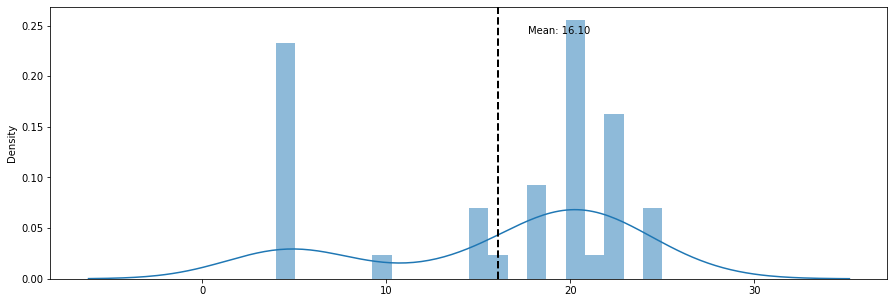

 number of points: 41
 number of papers: 16


KeyError: ignored

In [ ]:
#merged_dataset.groupby('virus_name_strain').agg('count')['temp'].sort_values

#make a function to sort dataset by whatever parameters provided above, print plots

merged_dataset_limited.groupby('virus_name_strain').agg('count').sort_values(by='temp')

pv_rates = merged_dataset_limited[merged_dataset_limited['virus_name_strain']=='ms2']

pv_rates['temp'] = pv_rates['temp'].astype(float)
temp_array = np.array(pv_rates['temp'])
plot_distribution(temp_array, 20)

point_num = len(pv_rates)
print(f" number of points: {point_num}")

paper_num = len(pv_rates.groupby('paper_ID').agg('count'))
print(f" number of papers: {paper_num}")

mean_k = np.mean(pv_rates['k_obs'])
print(f" mean k value: {mean_k}")

mean_std = np.std(pv_rates['k_obs'])
print(f" mean k value: {mean_std}")

fig, ax = plt.subplots(figsize = (12,6))
ax = pv_rates['buffer_type'].value_counts().plot.bar()
ax.set_ylabel("count"); ax.set_xlabel('buffer types')
for i in ax.patches:
    ax.text(x = i.get_x()+0.155, y = i.get_height()+5, s = i.get_height())
ax.tick_params(axis = 'x', labelsize = 12)
ax.set_title("Distribution of buffer")
plt.show()


pv_rates['buffer_type']

In [ ]:
merged_dataset.columns

Index(['virus_name_strain', 'temp', 'pH', 'paper_ID', 'kobs_mira',
       'purification_level', 'buffer_type', 'chlor_conc', 'sample_ID',
       'average_kobs', 'year', 'author_list', 'buffer_type_9_23',
       'corr_author', 'high_chloride', 'alpha_0', 'hocl_k_obs',
       'hocl_20C_k_obs', 'buffer', 'balt_class', 'family', 'genus', 'species',
       'shape', 'iep', 'structure', 'symmetry', 'tail', 'diameter',
       'CG_content', 'genome_length', 'C_percentage', 'G_percentage',
       'A_percentage', 'T_percentage', 'U_percentage', 'T_is_0', 'U_is_0'],
      dtype='object', name=0)

## Plots with the modified selection above

KeyboardInterrupt: ignored

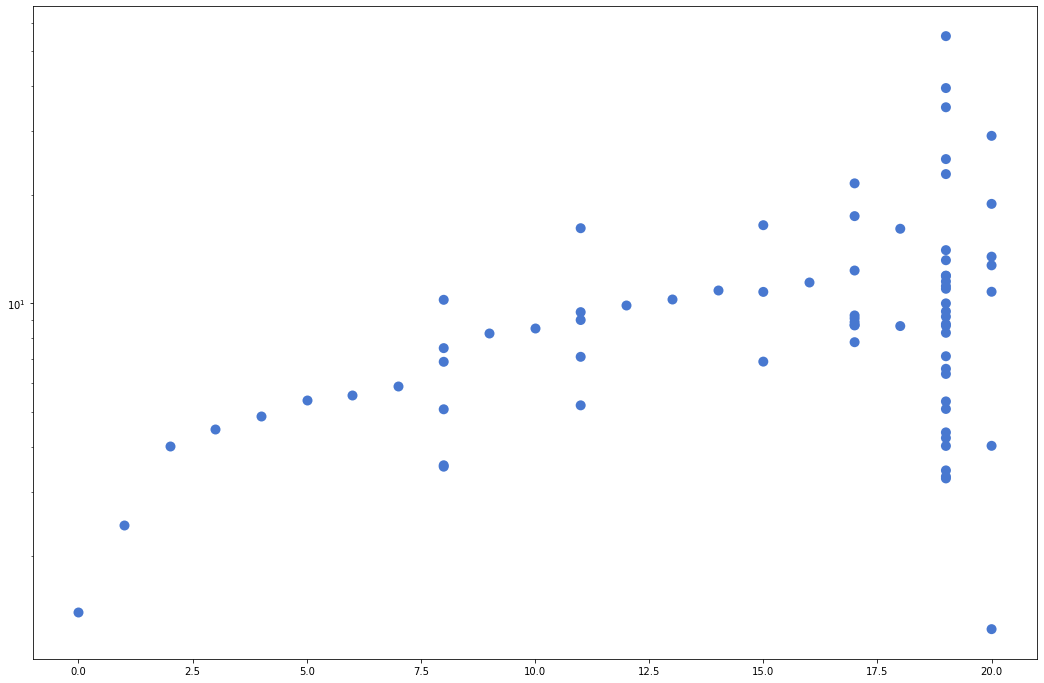

In [ ]:
#strip plot with everything

from google.colab import files

merged_dataset_strip = merged_dataset_limited
k_to_use = "hocl_20C_k_obs"

#make names shorter
merged_dataset_strip['virus_name_strain'] = merged_dataset_strip['virus_name_strain'].str.replace('infectious pancreatic necrosis virus powder mill strain','ipnv')
merged_dataset_strip['virus_name_strain'] = merged_dataset_strip['virus_name_strain'].str.replace('infectious hematopoietic necrosis virus wenatchee river strain','ihnv')
merged_dataset_strip['virus_name_strain'] = merged_dataset_strip['virus_name_strain'].str.replace('h5n1 a/chicken/hong kong/d-0947/2006','h5n1 hk')
merged_dataset_strip['virus_name_strain'] = merged_dataset_strip['virus_name_strain'].str.replace('h5n1 a/whooperswan/mongolia/244/2005','h5n1 mongolia')


#from matplotlib import gridspec

#divide virus by genome type
plus_ssRNA_viruses = merged_dataset_strip.loc[merged_dataset_strip['balt_class']=='+ssRNA']
plus_ssRNA_ordered_mean = plus_ssRNA_viruses.groupby('virus_name_strain').agg(np.mean)[k_to_use].sort_values(ascending = True)
order1 = plus_ssRNA_ordered_mean.index.tolist()


dsRNA_viruses = merged_dataset_strip.loc[merged_dataset_strip['balt_class']=='dsRNA']
dsRNA_ordered_mean = dsRNA_viruses.groupby('virus_name_strain').agg(np.mean)[k_to_use].sort_values(ascending = True)
order2 = dsRNA_ordered_mean.index.tolist()


dsDNA_viruses = merged_dataset_strip.loc[merged_dataset_strip['balt_class']=='dsDNA']
dsDNA_ordered_mean = dsDNA_viruses.groupby('virus_name_strain').agg(np.mean)[k_to_use].sort_values(ascending = True)
order3 = dsDNA_ordered_mean.index.tolist()

neg_ssRNA_viruses = merged_dataset_strip.loc[merged_dataset_strip['balt_class']=='-ssRNA']
neg_ssRNA_viruses_ordered_mean = neg_ssRNA_viruses.groupby('virus_name_strain').agg(np.mean)[k_to_use].sort_values(ascending = True)
order4 = neg_ssRNA_viruses_ordered_mean.index.tolist()

neg_ssRNA_viruses = merged_dataset_strip.loc[merged_dataset_strip['balt_class']=='ssDNA']
neg_ssRNA_viruses_ordered_mean = neg_ssRNA_viruses.groupby('virus_name_strain').agg(np.mean)[k_to_use].sort_values(ascending = True)
order5 = neg_ssRNA_viruses_ordered_mean.index.tolist()


order = order1 + order2 + order3 + order4 + order5

#make  stripplot
f, ax = plt.subplots( figsize=(18, 12))
ax.set_yscale("log")
sns.stripplot(s = 10, data = merged_dataset_strip, x = "virus_name_strain", y = k_to_use, order = order, jitter = False, palette="muted", hue = 'balt_class')

sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            order=order,
            x="virus_name_strain",
            y=k_to_use,
            data=merged_dataset_strip,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=ax)

#labels and legends
ylabel ="Log inactivation rate (L/(mg*min))"
plt.xticks(rotation=90, size = 20)
plt.yticks(size = 25)
ax.set_ylabel(ylabel, fontsize=30)
ax.legend( prop={'size': 30})
ax.set(xlabel=None)
#plt.title('Summary of Virus Inactivation Rates', fontsize = 35)

plt.tight_layout()

plt.savefig("virus_k_stripplot_below_pH8point5.png")
files.download("virus_k_stripplot_below_pH8point5.png") 


In [ ]:
#files.download("virus_k_stripplot_6_22.png")

In [ ]:
from google.colab import files

merged_dataset_strip = merged_dataset_limited

#make names shorter

#from matplotlib import gridspec

#divide virus by genome type
plus_ssRNA_viruses = merged_dataset_strip.loc[merged_dataset_strip['balt_class']=='+ssRNA']
plus_ssRNA_ordered_mean = plus_ssRNA_viruses.groupby('virus_name_strain').agg(np.mean)['k_obs'].sort_values(ascending = True)
order1 = plus_ssRNA_ordered_mean.index.tolist()

order = order1

#make  stripplot
f, ax = plt.subplots( figsize=(15, 10))
ax.set_yscale("log")
sns.stripplot(s = 15, data = plus_ssRNA_viruses, x = "virus_name_strain", y = "k_obs", order = order, jitter = False, palette="muted", hue = 'family')

sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            order=order,
            x="virus_name_strain",
            y="k_obs",
            data=plus_ssRNA_viruses,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=ax)

#labels and legends
ylabel ="Log inactivation rate (L/(mg*min))"
plt.xticks(rotation=90, size = 20)
plt.yticks(size = 25)
ax.set_ylabel(ylabel, fontsize=30)
ax.legend( prop={'size': 30})
ax.set(xlabel=None)
#plt.title('Summary of Virus Inactivation Rates', fontsize = 35)

plt.tight_layout()

plt.savefig("virus_k_stripplot_6_22.png")
files.download("virus_k_stripplot_6_22.png") 


In [ ]:
merged_dataset

,virus_name_strain,temp,pH,paper_ID,kobs_mira,purification_level,buffer_type,chlor_conc,sample_ID,average_kobs,...,diameter,CG_content,genome_length,C_percentage,G_percentage,A_percentage,T_percentage,U_percentage,T_is_0,U_is_0
0,cv b5 faulkner,20.0,7.5,2,7.06172048,2,buffer,1-3 mg/L,2-1,7.268857,...,30.0,47.77,7400,22.97297,24.7973,28.32432,0,23.90541,1,0
1,echo 11 gregory,20.0,7.5,2,4.874892,2,buffer,1-3 mg/L,2-2,4.663357,...,30.0,48.145,7438,23.78328,24.36139,28.09895,0,23.75639,1,0
2,cv b5 faulkner,20.0,7.0,3,7.102533,2,buffer,.1 mg/L initial,3-1,7.095708,...,30.0,47.77,7400,22.97297,24.7973,28.32432,0,23.90541,1,0
3,cv b5 faulkner,20.0,7.0,3,6.742764604,2,buffer,.5 mg/L initial,3-2,6.696142,...,30.0,47.77,7400,22.97297,24.7973,28.32432,0,23.90541,1,0
4,cv b5 faulkner,10.0,7.0,5,1.20945,2,wastewater,,5-1,1.209450,...,30.0,47.77,7400,22.97297,24.7973,28.32432,0,23.90541,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,ipnv,10.0,6.9,81,14.9373,2,ultrapure,.1 mg/L,81-1,15.238550,...,65.0,54.481,5881,29.195715,25.284816,29.671825,0,15.847645,1,0
558,ipnv,10.0,6.9,81,0.2432609404,2,surface water,.2 mg/L,81-2,0.249803,...,65.0,54.481,5881,29.195715,25.284816,29.671825,0,15.847645,1,0
559,ipnv,10.0,8.2,81,1.23219,2,surface water,.7 mg/L,81-3,1.245410,...,65.0,54.481,5881,29.195715,25.284816,29.671825,0,15.847645,1,0
560,ihnv,10.0,6.9,81,0.44996,2,surface water,.5 mg/L,81-5,0.467694,...,120.0,51.415,11131,27.38298,24.03198,29.04501,0,19.54002,1,0


## Viruses studied over time

In [ ]:
merged_dataset.groupby('virus_name_strain').agg('count').sort_values(by='temp', ascending = False).head(15)

#data_over_ten_points = 

,temp,pH,paper_ID,kobs_mira,purification_level,buffer_type,chlor_conc,sample_ID,average_kobs,year,...,diameter,CG_content,genome_length,C_percentage,G_percentage,A_percentage,T_percentage,U_percentage,T_is_0,U_is_0
virus_name_strain,,,,,,,,,,,,,,,,,,,,,
pv 1 mahoney,86,86,86,86,86,86,86,86,86,86,...,86,86,86,86,86,86,86,86,86,86
ms2,46,46,46,46,46,46,46,46,46,46,...,46,46,46,46,46,46,46,46,46,46
hadv 2,46,46,46,46,46,46,46,46,46,46,...,46,46,46,46,46,46,46,46,46,46
cv b5 faulkner,35,35,35,35,35,35,35,35,35,35,...,35,35,35,35,35,35,35,35,35,35
echo 1 farouk,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27
pv 1 sabin,26,26,26,26,26,26,26,26,26,26,...,26,26,26,26,26,26,26,26,26,26
qbeta,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
pr772,14,14,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,14,14,14,14
parvovirus h-1,14,14,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,14,14,14,14


In [ ]:

merged_dataset.groupby('virus_name_strain').agg('count')['temp'].sort_values

merged_dataset.groupby('virus_name_strain').agg('count').sort_values(by='temp', ascending = False)

#files.download("virus_k_stripplot_6_22.png") 

,temp,pH,paper_ID,kobs_mira,purification_level,buffer_type,chlor_conc,sample_ID,average_kobs,year,...,diameter,CG_content,genome_length,C_percentage,G_percentage,A_percentage,T_percentage,U_percentage,T_is_0,U_is_0
virus_name_strain,,,,,,,,,,,,,,,,,,,,,
pv 1 mahoney,86,86,86,86,86,86,86,86,86,86,...,86,86,86,86,86,86,86,86,86,86
ms2,46,46,46,46,46,46,46,46,46,46,...,46,46,46,46,46,46,46,46,46,46
hadv 2,46,46,46,46,46,46,46,46,46,46,...,46,46,46,46,46,46,46,46,46,46
cv b5 faulkner,35,35,35,35,35,35,35,35,35,35,...,35,35,35,35,35,35,35,35,35,35
echo 1 farouk,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ga bacteriophage,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
kilham rat virus,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
h1n1 a/pr/8/34,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


## Data shown for a single virus

In [27]:
merged_dataset_limited['average_kobs']

0       7.268857
1       4.663357
2       7.095708
3       6.696142
4       1.209450
         ...    
557    15.238550
558     0.249803
559     1.245410
560     0.467694
561     0.212447
Name: average_kobs, Length: 562, dtype: float64

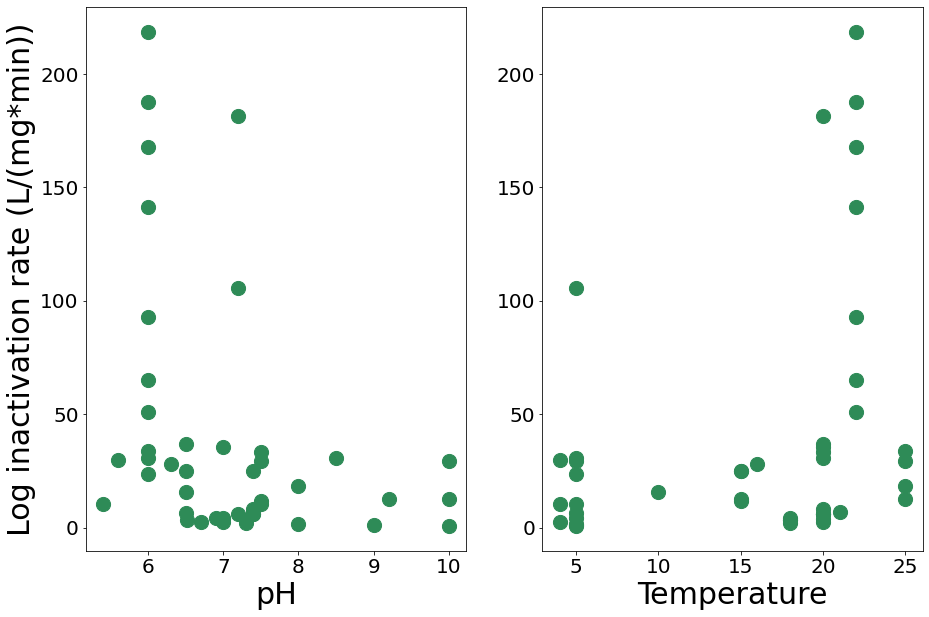

In [30]:
virus = 'ms2'

#use dataset with modified experimental parameters
single_virus_constants = merged_dataset_limited[merged_dataset_limited['virus_name_strain']== virus]

#remove outlier
#single_virus_constants = single_virus_constants[single_virus_constants['k_obs'] < 100]

f, axes = plt.subplots(1, 2, figsize=(15, 10))
ax1 = axes[0]
ax1.scatter(data=single_virus_constants, x = 'pH', y = 'average_kobs', s = 200, c = 'seagreen')
ax1.set_xlabel('pH', fontsize=30)
ax1.set_ylabel("Log inactivation rate (L/(mg*min))", fontsize=30)
ax1.tick_params(axis='both', which='major', labelsize=20)
x = single_virus_constants['pH']
y = single_virus_constants['average_kobs']
#m, b = np.polyfit(x, y, 1)
#ax1.plot(x, m*x+b, c = 'orange')


ax2 = axes[1]
ax2.scatter(data=single_virus_constants, x = 'temp', y = 'average_kobs', s = 200,  c = 'seagreen')
ax2.set_xlabel('Temperature', fontsize=30)
ax2.tick_params(axis='both', which='major', labelsize=20)
x = single_virus_constants['temp']
y = single_virus_constants['average_kobs']
#m, b = np.polyfit(x, y, 1)
#ax2.plot(x, m*x+b,  c = 'orange')


In [ ]:
merged_dataset_limited[merged_dataset_limited['virus_name_strain']=='ms2']

,virus_name_strain,temp,pH,paper_ID,kobs_mira,purification_level,buffer_type,chlor_conc,sample_ID,average_kobs,...,diameter,CG_content,genome_length,C_percentage,G_percentage,A_percentage,T_percentage,U_percentage,T_is_0,U_is_0
10,ms2,15.0,7.50,7,11.96,3,groundwater,.09 - .67 mg/L initial,7-1,11.960740,...,27.35,52.115,3569,26.14178,25.97366,23.39591,0,24.48865,1,0
12,ms2,15.0,7.40,7,24.89,3,groundwater,.09 - .67 mg/L initial,7-3,24.891406,...,27.35,52.115,3569,26.14178,25.97366,23.39591,0,24.48865,1,0
13,ms2,16.0,6.30,7,28.08,3,groundwater,.09 - .67 mg/L initial,7-4,28.080153,...,27.35,52.115,3569,26.14178,25.97366,23.39591,0,24.48865,1,0
14,ms2,25.0,7.50,7,29.52,3,groundwater,.09 - .67 mg/L initial,7-5,29.520161,...,27.35,52.115,3569,26.14178,25.97366,23.39591,0,24.48865,1,0
15,ms2,5.0,7.50,7,10.37,3,groundwater,.09 - .67 mg/L initial,7-6,10.371002,...,27.35,52.115,3569,26.14178,25.97366,23.39591,0,24.48865,1,0
22,ms2,21.0,7.40,9,7.172582266,3,wastewater,,9-1,7.167001,...,27.35,52.115,3569,26.14178,25.97366,23.39591,0,24.48865,1,0
34,ms2,20.0,7.40,10,5.94223,2,buffer,.8 - 3.1 mg/L,10-12,5.921115,...,27.35,52.115,3569,26.14178,25.97366,23.39591,0,24.48865,1,0
35,ms2,4.0,5.40,11,10.6997,2,agricultural,,11-1,10.644772,...,27.35,52.115,3569,26.14178,25.97366,23.39591,0,24.48865,1,0
36,ms2,4.0,5.60,11,35.52844745,2,agricultural,,11-2,29.988321,...,27.35,52.115,3569,26.14178,25.97366,23.39591,0,24.48865,1,0
37,ms2,4.0,6.70,11,2.394280163,2,agricultural,,11-3,2.387870,...,27.35,52.115,3569,26.14178,25.97366,23.39591,0,24.48865,1,0


**bold text**# New Section

In [ ]:
# Check if average_kobs is in merged_dataset (Kaming)
merged_dataset.columns

Index(['virus_name_strain', 'temp', 'pH', 'paper_ID', 'kobs_mira',
       'purification_level', 'buffer_type', 'chlor_conc', 'sample_ID',
       'average_kobs', 'year', 'author_list', 'buffer_type_9_23',
       'corr_author', 'high_chloride', 'alpha_0', 'hocl_k_obs',
       'hocl_20C_k_obs', 'buffer', 'balt_class', 'family', 'genus', 'species',
       'shape', 'iep', 'structure', 'symmetry', 'tail', 'diameter',
       'CG_content', 'genome_length', 'C_percentage', 'G_percentage',
       'A_percentage', 'T_percentage', 'U_percentage', 'T_is_0', 'U_is_0'],
      dtype='object', name=0)

In [ ]:
# Check nan values
print(merged_dataset.shape)
merged_dataset.isnull().sum()

(562, 38)


0
virus_name_strain     0
temp                  0
pH                    0
paper_ID              0
kobs_mira             0
purification_level    0
buffer_type           0
chlor_conc            0
sample_ID             0
average_kobs          0
year                  0
author_list           0
buffer_type_9_23      0
corr_author           0
high_chloride         0
alpha_0               0
hocl_k_obs            0
hocl_20C_k_obs        0
buffer                0
balt_class            0
family                0
genus                 0
species               0
shape                 0
iep                   0
structure             0
symmetry              0
tail                  0
diameter              0
CG_content            0
genome_length         0
C_percentage          0
G_percentage          0
A_percentage          0
T_percentage          0
U_percentage          0
T_is_0                0
U_is_0                0
dtype: int64

In [ ]:
from google.colab import files

merged_dataset.to_excel("merged_df_10_2_22.xlsx")
files.download("merged_df_10_2_22.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
np.unique(merged_dataset['corr_author'])

array(['', "[ 'kohn_t']", "[ 'liu_y', 'liu_x']", "[ 'moulin_l']",
       "['adcock_n']", "['bates_r']", "['berg_g']", "['berman_d']",
       "['bosch_a']", "['dennis jr._w']", "['gerba_c']", "['girones_r']",
       "['grabow_w']", "['grunert_a']", "['hill_v']", "['ikehata_k']",
       "['johnson_j']", "['kahler_a']", "['keegan_a']", "['kitajima_m']",
       "['ko_g']", "['kohn_t']", "['lenes_d']", "['li_j']", "['ma_j']",
       "['mariñas_b']", "['mariñas_b']\n", "['obrien_r']", "['oguma_k']",
       "['payment_p']", "['rice_e']", "['sano_d']", "['schwab_k']",
       "['shaffer_p']", "['shang_c']", "['sharp_d']", "['shin_g']",
       "['shirasaki_n']", "['thurston-enriquez_j']", "['trieff_n']",
       "['vaughn_j']", "['wallis_c']", "['wang_j', 'li_j']",
       "['weidenkopf_s']", "['wigginton_k']", "['young_d']"], dtype=object)

# Network Analysis

In [ ]:
df_pivot = pd.pivot_table(data = merged_dataset, index = 'corr_author', values = 'paper_ID', aggfunc = 'nunique', sort = True )

df_pivot.sort_values(by='paper_ID', ascending = False)

,paper_ID
corr_author,
['kohn_t'],5
['mariñas_b'],4
['sharp_d'],4
['berg_g'],3
['sobsey_m'],2
['oguma_k'],2
['kahler_a'],2
['shin_g'],2
['haas_c'],2


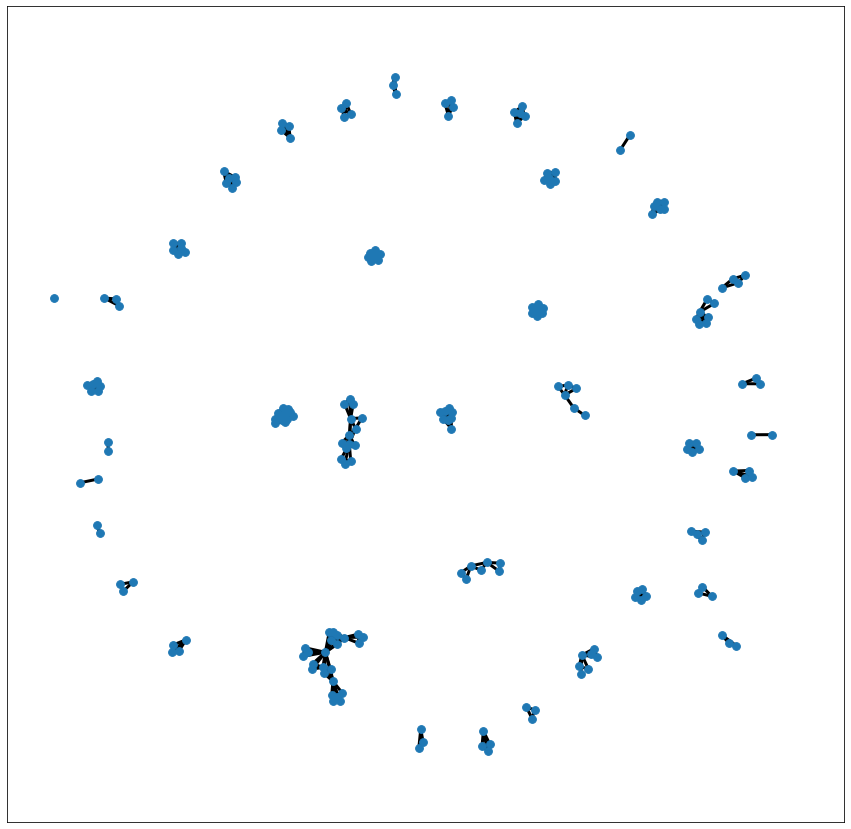

<Figure size 432x288 with 0 Axes>

In [ ]:
import networkx as nx

#make list of unique authors to use as nodes
authors = merged_dataset['author_list']
author_list = []
for i in authors:
  brackets_removed = i.replace('[','').replace(']','').replace("'","")
  x = brackets_removed.split(', ')
  for j in x: 
    author_list.append(j)

array_author = np.array(author_list)
array_author = np.where(array_author == "thurston-enriquez_j","thurston_j",array_author)
#array_author = np.array(author_list)
unique_authors = np.unique(array_author)

#find edges - make list of author pairs
agg_obj = merged_dataset.groupby("paper_ID").aggregate(lambda tdf: tdf.unique().tolist())
type(agg_obj['author_list'])
agg_obj_ind = agg_obj['author_list'].reset_index()

#agg_obj_ind
list_ser = agg_obj_ind['author_list']

authors_by_paper = []
author_tuples = []
for row in list_ser:
  names = row[0]
  brackets_removed = names.replace('[','').replace(']','').replace("'","").replace("thurston-enriquez_j","thurston_j")
  x = brackets_removed.split(', ')
  authors_by_paper.append(x)
  for i in range(0,len(x)):
    for j in range(i+1, len(x)):
      author_tuples.append((x[i],x[j]))


#make network
G = nx.Graph()
G.add_nodes_from(unique_authors)
G.add_edges_from(author_tuples)

f, ax = plt.subplots( figsize=(15, 15))
#pos = nx.kamada_kawai_layout(G)

nx.draw_networkx(G, with_labels = False, node_size = 60, width = 3)
plt.show()
plt.savefig("network_analysis.png")
#files.download("network_analysis.png") 

#for i in #data structure where each paper has a row listing all of its authors (i is one row)


#merged_dataset['author_list']


In [ ]:
list(nx.connected_components(G))

[G.subgraph(c) for c in *_components]



SyntaxError: ignored

(array([208.,   0.,   1.,   2.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([0.        , 0.0007489 , 0.00149781, 0.00224671, 0.00299562,
        0.00374452, 0.00449343, 0.00524233, 0.00599124, 0.00674014,
        0.00748905]),
 <a list of 10 Patch objects>)

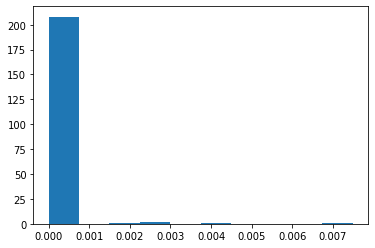

In [ ]:
bet_cent = nx.betweenness_centrality(G)
plt.hist(bet_cent.values())


In [ ]:
author_tuples

[('young_s', 'torrey_j'),
 ('young_s', 'bachmann_v'),
 ('young_s', 'kohn_t'),
 ('torrey_j', 'bachmann_v'),
 ('torrey_j', 'kohn_t'),
 ('bachmann_v', 'kohn_t'),
 ('shirasaki_n', 'matsushita_t'),
 ('shirasaki_n', 'matsui_y'),
 ('shirasaki_n', 'koriki_s'),
 ('matsushita_t', 'matsui_y'),
 ('matsushita_t', 'koriki_s'),
 ('matsui_y', 'koriki_s'),
 ('wati_s', 'robinson_b'),
 ('wati_s', 'mieog_j'),
 ('wati_s', 'blackbeard_j'),
 ('wati_s', 'keegan_a'),
 ('robinson_b', 'mieog_j'),
 ('robinson_b', 'blackbeard_j'),
 ('robinson_b', 'keegan_a'),
 ('mieog_j', 'blackbeard_j'),
 ('mieog_j', 'keegan_a'),
 ('blackbeard_j', 'keegan_a'),
 ('kadoya_s', 'nishimura_o'),
 ('kadoya_s', 'kato_h'),
 ('kadoya_s', 'sano_d'),
 ('nishimura_o', 'kato_h'),
 ('nishimura_o', 'sano_d'),
 ('kato_h', 'sano_d'),
 ('grunert_a', 'frohnert_a'),
 ('grunert_a', 'selinka_h'),
 ('grunert_a', 'szewzyk_r'),
 ('frohnert_a', 'selinka_h'),
 ('frohnert_a', 'szewzyk_r'),
 ('selinka_h', 'szewzyk_r'),
 ('ye_y', 'chang_p'),
 ('ye_y', 'hartert

In [ ]:
nx.betweenness_centrality(G)

{'abad_f': 5.961429550806284e-05,
 'adcock_n': 0.0,
 'akin_e': 0.0,
 'alexandre_v': 0.0,
 'andrews_r': 0.0,
 'anmangandla_u': 0.0,
 'bachmann_v': 0.000357685773048377,
 'bates_r': 0.000357685773048377,
 'baxter_c': 0.0,
 'berg_g': 0.000357685773048377,
 'berman_d': 0.0,
 'black_s': 0.0,
 'blackbeard_j': 0.0,
 'boardman_g': 0.0,
 'bosch_a': 5.961429550806284e-05,
 'bosshard_f': 0.0,
 'brashear_d': 0.0,
 'brown_j': 0.0,
 'brown_m': 0.0,
 'butler_m': 0.0,
 'caballero_s': 0.0,
 'cai_x': 0.0,
 'calgua_b': 0.0,
 'calvo_m': 0.0,
 'carratala_a': 0.004023964946794242,
 'cascella_m': 0.0,
 'chang_p': 0.0,
 'chang_s': 0.0,
 'chen_y': 0.0,
 'chen_z': 0.0,
 'cheung_l': 0.0,
 'churn_c': 0.0,
 'cohen_j': 0.0,
 'cromeans_t': 2.9807147754031416e-05,
 'dahling_d': 0.0,
 'dai_r': 0.0,
 'deboosere_n': 0.0,
 'deinhardt_f': 0.0,
 'dennis jr._w': 0.0,
 'diez_j': 0.0,
 'dunkin_n': 0.0,
 'emerson_s': 0.0,
 'engelbrecht_r': 0.0,
 'floyd_r': 0.0,
 'frohnert_a': 0.0,
 'fuji_t': 2.2355360815523562e-05,
 'gall_a': 

In [ ]:
type([("A","C"), ("B","D"), ("B"","E"), ("C", "E")])

SyntaxError: ignored